# Fasttext Encoding + Random Forest Classifier

In [20]:
#importing libraries

# data manipulation
import pandas as pd
import numpy as np

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# encoding text information usinf fasttext encoder
from embedding_as_service.text.encode import Encoder

# scikit model used
from sklearn.ensemble import RandomForestClassifier

# hypertuning model
from sklearn.model_selection import RandomizedSearchCV

# metrics for model evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#removing warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('/content/ticket_train.csv')
valid = pd.read_csv('/content/ticket_valid.csv')

## Fasttext Encoding

In [3]:
# initialising encoder
fasttext_en = Encoder(embedding='fasttext', model='common_crawl_300')

Model does not exists, Downloading model: common_crawl_300
[||||||||||||||||||||||||||||||||||||||||||||||||||] 100 % [1488071/1488071 kb]


900it [00:00, 8988.22it/s]

Model downloaded successfully!
Loading Model (this might take few minutes).....


1999995it [03:58, 8371.33it/s]

Model loaded Successfully !


### Encoding training datasets

In [4]:
# encoding training dataset
fasttext_train_vecs = fasttext_en.encode(texts = list(train['info'].values), pooling='reduce_mean')

In [5]:
fasttext_train_vecs.shape

(38839, 300)

In [6]:
fasttext_train_vecs

array([[ 0.00728672, -0.00506562, -0.00520078, ...,  0.01057891,
        -0.00600937, -0.00492188],
       [ 0.00256172,  0.00128047, -0.00835781, ..., -0.01101406,
         0.00139844,  0.01202734],
       [-0.00926875,  0.02020156, -0.00615312, ..., -0.01895   ,
        -0.00510313, -0.00916797],
       ...,
       [ 0.00094297, -0.00193359, -0.01193906, ..., -0.00394609,
         0.00141016, -0.00152422],
       [-0.00793906,  0.02531172, -0.01642422, ..., -0.00886953,
         0.00726953, -0.000475  ],
       [ 0.00910469,  0.04631719, -0.04369141, ...,  0.00188672,
        -0.10274141, -0.05983047]])

### Encoding validating datasets

In [7]:
# encoding validation dataset
fasttext_valid_vecs = fasttext_en.encode(texts = list(valid['info'].values), pooling='reduce_mean')

In [8]:
fasttext_valid_vecs.shape

(4855, 300)

## Modelling

In [9]:
# creating Random Forest Classifier instance
RFClf = RandomForestClassifier(random_state=35)

In [10]:
# fitting the model with training fasttext encoded vector and target ticket_type column
RFClf.fit(fasttext_train_vecs, train['ticket_type'])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=35, verbose=0,
                       warm_start=False)

In [11]:
# predicting validating dataset ticket-type using validation fasttext encoded vector
y_valid_preds = RFClf.predict(fasttext_valid_vecs)

## Model Evaluation

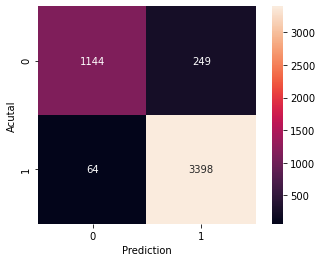

In [12]:
con_mat = confusion_matrix(valid['ticket_type'], y_valid_preds)
sns.heatmap(con_mat, annot=True, fmt='.0f', square=True)
plt.xlabel('Prediction')
plt.ylabel('Acutal')
plt.show()

In [13]:
acc = accuracy_score(valid['ticket_type'], y_valid_preds)
print(f'Model accuracy score = {acc*100:0.2f}%.')

Model accuracy score = 93.55%.


In [14]:
print(classification_report(valid['ticket_type'], y_valid_preds))

              precision    recall  f1-score   support

           0       0.95      0.82      0.88      1393
           1       0.93      0.98      0.96      3462

    accuracy                           0.94      4855
   macro avg       0.94      0.90      0.92      4855
weighted avg       0.94      0.94      0.93      4855



### With class-weight='balanced'

In [15]:
# creating Random Forest Classifier instance
RFClf_bal = RandomForestClassifier(random_state=35, class_weight='balanced')

# fitting the model with training fasttext encoded vector and target ticket_type column
RFClf_bal.fit(fasttext_train_vecs, train['ticket_type'])

# predicting validating dataset ticket-type using validation fasttext encoded vector
y_valid_preds_bal = RFClf_bal.predict(fasttext_valid_vecs)

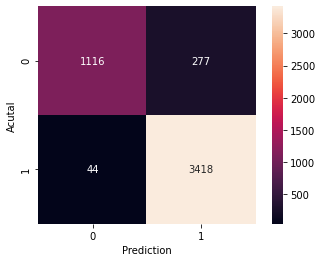

In [16]:
con_mat = confusion_matrix(valid['ticket_type'], y_valid_preds_bal)
sns.heatmap(con_mat, annot=True, fmt='.0f', square=True)
plt.xlabel('Prediction')
plt.ylabel('Acutal')
plt.show()

In [17]:
acc = accuracy_score(valid['ticket_type'], y_valid_preds_bal)
print(f'Model accuracy score = {acc*100:0.2f}%.')

Model accuracy score = 93.39%.


In [18]:
print(classification_report(valid['ticket_type'], y_valid_preds_bal))

              precision    recall  f1-score   support

           0       0.96      0.80      0.87      1393
           1       0.93      0.99      0.96      3462

    accuracy                           0.93      4855
   macro avg       0.94      0.89      0.91      4855
weighted avg       0.94      0.93      0.93      4855



## Hypertuning the model

In [21]:
# grid for randomized search
params_grid = {'n_estimators' : np.arange(10,100,10),
        'max_depth' : [None, 3, 5, 10],
        'criterion' : ['gini', 'entropy']}

In [27]:
# initiating new Random Forest Classifier instance
clf = RandomForestClassifier(random_state=35, class_weight='balanced')

# creating a hyper-tuned model
ht_clf = RandomizedSearchCV(estimator = clf,
                            param_distributions = params_grid,
                            n_iter = 10,
                            cv = 3,
                            verbose = True)

In [28]:
ht_clf.fit(fasttext_train_vecs, train['ticket_type'])

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  7.8min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight='balanced',
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
         

In [29]:
# best parameters
ht_clf.best_params_

{'criterion': 'entropy', 'max_depth': None, 'n_estimators': 50}

In [36]:
# maximum score achieved on training dataset
ht_clf.best_score_

0.9318210425942288

## Initialising Final HyperTuned Model

In [30]:
# creating final model
final_model = RandomForestClassifier(random_state = 35,
                                     class_weight = 'balanced',
                                     criterion = 'entropy',
                                     max_depth = None,
                                     n_estimators = 50)

In [31]:
# fitting final model
final_model.fit(fasttext_train_vecs, train['ticket_type'])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=35, verbose=0,
                       warm_start=False)

In [22]:
# importing testing dataset
test = pd.read_csv('/content/ticket_test.csv')

In [23]:
# encoding testing dataset
fasttext_test_vecs = fasttext_en.encode(texts = list(test['info'].values), pooling='reduce_mean')

In [32]:
# predicting validating dataset ticket-type using validation fasttext encoded vector
y_test_preds = final_model.predict(fasttext_test_vecs)

### Final Model Evaluation

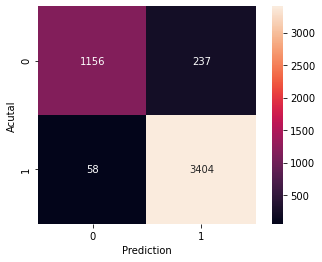

In [33]:
con_mat = confusion_matrix(test['ticket_type'], y_test_preds)
sns.heatmap(con_mat, annot=True, fmt='.0f', square=True)
plt.xlabel('Prediction')
plt.ylabel('Acutal')
plt.show()

In [34]:
acc = accuracy_score(test['ticket_type'], y_test_preds)
print(f'Model accuracy score = {acc*100:0.2f}%.')

Model accuracy score = 93.92%.


In [35]:
print(classification_report(test['ticket_type'], y_test_preds))

              precision    recall  f1-score   support

           0       0.95      0.83      0.89      1393
           1       0.93      0.98      0.96      3462

    accuracy                           0.94      4855
   macro avg       0.94      0.91      0.92      4855
weighted avg       0.94      0.94      0.94      4855

